In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [226]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3,out_channels=32,kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*16*16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), 64*16*16)
        # x.reshape(x.shape[0], -1)
        # x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x


In [227]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [228]:
train = r'C:\Users\DHAIRYA\AIDL_LTI_Neural_Networks\Python\dataset\training_set'
test = r'C:\Users\DHAIRYA\AIDL_LTI_Neural_Networks\Python\dataset\test_set'

In [229]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [230]:
train_data = datasets.ImageFolder(train, transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [231]:
test_data = datasets.ImageFolder(test, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


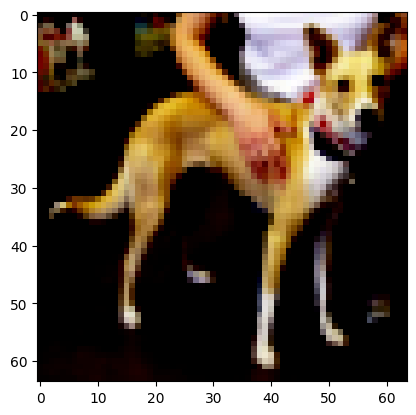

In [239]:
train_data[1][0].shape

npimage = train_data[7000][0].numpy()
plt.imshow(np.transpose(npimage, (1, 2, 0)))
plt.show()

In [233]:
model = CNN().to(device)

In [234]:
critereon = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [235]:
epochs = 10

for epoch in range(epochs):
    # print(f"Epoch {epoch+1}/{epochs}")
    for batch, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device).float().view(-1, 1)  # Reshape target to match scores

        scores = model(data)
        loss = critereon(scores, target)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

Epoch [1/10], Loss: 0.7379
Epoch [2/10], Loss: 0.6167
Epoch [3/10], Loss: 0.4148
Epoch [4/10], Loss: 0.3624
Epoch [5/10], Loss: 0.3146
Epoch [6/10], Loss: 0.1982
Epoch [7/10], Loss: 0.0423
Epoch [8/10], Loss: 0.1768
Epoch [9/10], Loss: 0.0759
Epoch [10/10], Loss: 0.0048


## Model Evaluation

In [236]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float().view(-1, 1)

            scores = model(x)
            predictions = torch.round(scores)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")

    model.train()

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 7924 / 8000 with accuracy 99.05
Got 1479 / 2000 with accuracy 73.95


In [237]:
from PIL import Image

## Single Prediction

In [ ]:
image_path = r'C:\Users\DHAIRYA\AIDL_LTI_Neural_Networks\Python\dataset\single_prediction\cat_or_dog_2.jpg'

image = Image.open(image_path)

# Apply the transformation
image = test_transforms(image)
image = image.unsqueeze(0).to(device)

with torch.no_grad():  # Turn off gradients since we are in inference mode
    output = model(image)  # Pass the image through the model

# Get the predicted class (for binary classification, output is between 0 and 1)
prediction = output.item()  # Get the scalar value from the tensor
print(f"Prediction (raw output): {prediction}")

# Convert the raw output to a class (e.g., if prediction > 0.5, it's class 1; otherwise, it's class 0)
if prediction > 0.5:
    print("Prediction: Dog")  # Assuming class 1 is Dog
else:
    print("Prediction: Cat")  # Assuming class 0 is Cat


Prediction (raw output): 0.0079103484749794
Prediction: Cat
